# Download and load data

In [1]:
from sklearn.datasets import fetch_openml
mnist_x, mnist_y = fetch_openml('mnist_784', return_X_y=True, as_frame=True)

In [2]:
import numpy as np
nrows_train, nrows_test, dtype = 60000, 10000, np.float32
x_train = np.ascontiguousarray(mnist_x.values[:nrows_train], dtype=dtype)
x_test = np.ascontiguousarray(mnist_x.values[nrows_train:nrows_train+nrows_test], dtype=dtype)
y_train = np.ascontiguousarray(mnist_y.values[:nrows_train], dtype=int)
y_test = np.ascontiguousarray(mnist_y.values[nrows_train:nrows_train+nrows_test], dtype=int)
print(f'x_train shape: {x_train.shape}, x_test shape: {x_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

x_train shape: (60000, 784), x_test shape: (10000, 784), y_train shape: (60000,), y_test shape: (10000,)


# Visualize data

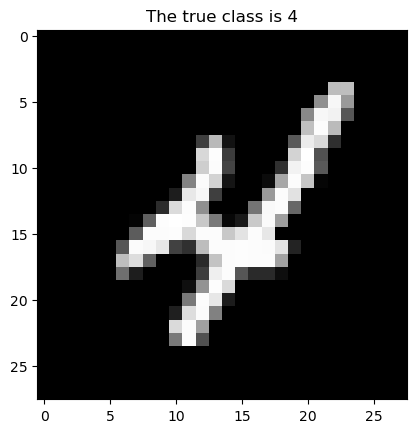

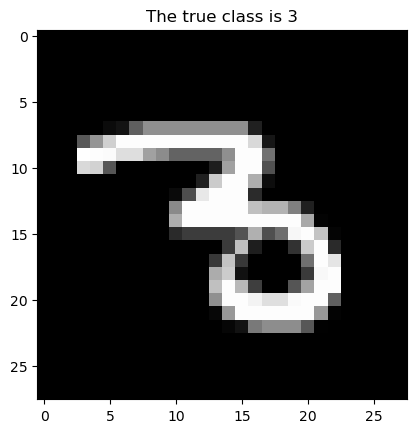

In [3]:
import matplotlib.pyplot as plt
plt.imshow(np.reshape(x_train[9], (-1,28)), cmap = 'gray')
plt.title(f'The true class is {y_train[9]}')
plt.show()
plt.imshow(np.reshape(x_train[30], (-1,28)), cmap = 'gray')
plt.title(f'The true class is {y_train[30]}')
plt.show()

# Preprocess

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
n_classes = 10
y_train = np.identity(n_classes)[y_train]
y_test = np.identity(n_classes)[y_test]

# Activation functions

In [5]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss function

In [6]:
def cross_entropy_loss(x, y):
    return np.mean(-np.sum(x * np.log(y), axis=1))

# Compute accuracy

In [7]:
def accuracy_score(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

# Create custom NN

In [8]:
from time import time
import logging
logging.basicConfig(stream = sys.stdout, level = logging.INFO)
logger = logging.getLogger()



class Custom_NN:
    def __init__(
            self,
            input_layer_size,
            hidden_layer_size,
            output_layer_size,
            hidden_activation_func,
            output_activation_func,
            loss_function,
            lr,
            batch_size,
            num_epochs):
        self.W = [np.random.randn(input_layer_size, hidden_layer_size) * np.sqrt(2 / (hidden_layer_size+input_layer_size)),
                  np.random.randn(hidden_layer_size, output_layer_size) * np.sqrt(2 / (hidden_layer_size+input_layer_size))]
        self.b = [np.zeros([1, hidden_layer_size]), np.zeros([1, output_layer_size])]
        self.hidden_activation_func = hidden_activation_func
        self.output_activation_func = output_activation_func
        self.loss_function = loss_function
        self.lr = lr
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.t = [np.ndarray((batch_size, hidden_layer_size), np.float32), np.ndarray((batch_size, output_layer_size), np.float32)]
        self.t_derivative = [np.ndarray((batch_size, hidden_layer_size), np.float32), np.ndarray((batch_size, output_layer_size), np.float32)]
        self.W_derivative = [np.ndarray((input_layer_size, hidden_layer_size), np.float32), np.ndarray((hidden_layer_size, output_layer_size), np.float32)]
        self.b_derivative = [np.ndarray((1, hidden_layer_size), np.float32), np.ndarray((1, output_layer_size), np.float32)]
        

    def forward(self, x):
        self.t[0] = np.matmul(x, self.W[0]) + self.b[0]
        self.hidden_activation = self.hidden_activation_func(self.t[0])
        self.t[1] = np.matmul(self.hidden_activation, self.W[1]) + self.b[1]
        self.output_activation = self.output_activation_func(self.t[1])

    def backward(self, x, y):
        self.t_derivative[1] = (self.output_activation - y) / self.output_activation.shape[0]
        self.W_derivative[1] = np.matmul(self.hidden_activation.T, self.t_derivative[1])
        self.b_derivative[1] = np.sum(self.t_derivative[1], axis=0, keepdims=True)
        self.t_derivative[0] = np.matmul(self.t_derivative[1], self.W[1].T) * np.where(self.t[0] > 0, 1, 0)
        self.W_derivative[0] = np.matmul(x.T, self.t_derivative[0])
        self.b_derivative[0] = np.sum(self.t_derivative[0], axis=0, keepdims=True)

        for i in range(2):
            self.W[i] -= self.lr * self.W_derivative[i]
            self.b[i] -= self.lr * self.b_derivative[i]

    def train(self, x, y):
        overal_time = 0
        samples_count = x.shape[0]
        batch_size = self.batch_size

        logger.info("Starting training")
        logger.info(f"learning_rate = {self.lr}, num_epochs = {self.num_epochs}, batch_size = {batch_size}")
        for epoch in range(self.num_epochs):
            start_time = time()

            epoch_error_sum = 0

            for i in range(0, samples_count, batch_size):
                batch_end = samples_count if (i + batch_size >= samples_count) else i + batch_size

                x_batch = x[i : batch_end]
                y_batch = y[i : batch_end]

                self.forward(x_batch)
                epoch_error_sum += self.loss_function(y_batch, self.output_activation)
                self.backward(x_batch, y_batch)
                
            end_time = time() - start_time
            overal_time += end_time

            epoch_error_mean = epoch_error_sum / samples_count

            self.forward(x)

            accuracy = accuracy_score(y, self.output_activation)

            logger.info('Epoch[{}]: error = {}, accuracy = {}, time = {} sec'.
                        format(epoch, epoch_error_mean, accuracy, end_time))

        logger.info(f"Overall training time: {overal_time} sec")

    def predict(self, x_test):
        self.forward(x_test)
        return self.output_activation

# Run training

In [9]:
input_layer_size = 28 * 28
hidden_layer_size = 300
output_layer_size = 10
hidden_activation_func = relu
output_activation_func = softmax
loss_function = cross_entropy_loss
lr = 0.1
batch_size = 64
num_epochs = 20

model = Custom_NN(input_layer_size,
                  hidden_layer_size,
                  output_layer_size,
                  hidden_activation_func,
                  output_activation_func,
                  loss_function,
                  lr,
                  batch_size,
                  num_epochs)

model.train(x_train, y_train)

INFO:root:Starting training
INFO:root:learning_rate = 0.1, num_epochs = 20, batch_size = 64
INFO:root:Epoch[0]: error = 0.0062647526610366345, accuracy = 0.9269833333333334, time = 0.5407118797302246 sec
INFO:root:Epoch[1]: error = 0.0032331398750959895, accuracy = 0.9476166666666667, time = 0.5217394828796387 sec
INFO:root:Epoch[2]: error = 0.0024017305054818924, accuracy = 0.9601833333333334, time = 0.5208935737609863 sec
INFO:root:Epoch[3]: error = 0.00191174302628059, accuracy = 0.9674666666666667, time = 0.5168056488037109 sec
INFO:root:Epoch[4]: error = 0.0015830576700439794, accuracy = 0.9729833333333333, time = 0.5226731300354004 sec
INFO:root:Epoch[5]: error = 0.0013460010148782318, accuracy = 0.9767666666666667, time = 0.5170648097991943 sec
INFO:root:Epoch[6]: error = 0.001166165014174195, accuracy = 0.97975, time = 0.5205340385437012 sec
INFO:root:Epoch[7]: error = 0.0010241381516377607, accuracy = 0.9820333333333333, time = 0.5155291557312012 sec
INFO:root:Epoch[8]: error 

# Run predict

In [10]:
logger.info(f"Accuracy on test data: {accuracy_score(y_test, model.predict(x_test))}")

INFO:root:Accuracy on test data: 0.9791


# Compare with torch

In [11]:
import torch
from torch import nn
import torch.nn.functional as F

class Torch_NN(nn.Module):
    def __init__(self):
      super().__init__()
      self.layer1 = nn.Linear(input_layer_size, hidden_layer_size)
      self.relu = nn.ReLU()
      self.layer2 = nn.Linear(hidden_layer_size, output_layer_size)
    def forward(self, x):
      x = self.layer1(x)
      x = self.relu(x)
      x = self.layer2(x)
      x = F.log_softmax(x)
      return x

In [12]:
torch_model = Torch_NN()
torch_model

Torch_NN(
  (layer1): Linear(in_features=784, out_features=300, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=300, out_features=10, bias=True)
)

In [13]:
torch_loss_function = nn.CrossEntropyLoss() 
torch_optimizer = torch.optim.SGD(torch_model.parameters(), lr = lr) 

from torch.autograd import Variable
overal_time = 0
samples_count = x_train.shape[0]

for epoch in range(num_epochs):
    for i in range(0, samples_count, batch_size):
        start_time = time()
        batch_end = samples_count if (i + batch_size >= samples_count) else i + batch_size

        x_batch = x_train[i : batch_end]
        y_batch = y_train[i : batch_end]

        x_variable = Variable(torch.tensor(x_batch))
        y_variable = Variable(torch.tensor(y_batch))

        outputs = torch_model(x_variable) 
        loss = torch_loss_function(outputs, y_variable)

        torch_optimizer.zero_grad() 
        loss.backward() 
        torch_optimizer.step()

    end_time = time() - start_time
    overal_time += end_time

    accuracy = accuracy_score(y_train, torch_model(torch.tensor(x_train)).detach().numpy())
    logger.info('Epoch[{}]: error = {}, accuracy = {}, time = {} sec'.
            format(epoch, loss.data, accuracy, end_time))

logger.info(f"Overall training time: {overal_time} sec")


/tmp/ipykernel_40063/3286037995.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


INFO:root:Epoch[0]: error = 0.10754882557375822, accuracy = 0.9222, time = 0.0002970695495605469 sec
INFO:root:Epoch[1]: error = 0.05186586270838234, accuracy = 0.9461, time = 0.0003597736358642578 sec
INFO:root:Epoch[2]: error = 0.03510199816491877, accuracy = 0.95875, time = 0.0003001689910888672 sec
INFO:root:Epoch[3]: error = 0.028513603449482616, accuracy = 0.9666166666666667, time = 0.0002970695495605469 sec
INFO:root:Epoch[4]: error = 0.025258691478711626, accuracy = 0.9729333333333333, time = 0.00030350685119628906 sec
INFO:root:Epoch[5]: error = 0.02308775650521966, accuracy = 0.97695, time = 0.0003104209899902344 sec
INFO:root:Epoch[6]: error = 0.022368456427329875, accuracy = 0.9799, time = 0.0002944469451904297 sec
INFO:root:Epoch[7]: error = 0.020575459681651864, accuracy = 0.9822833333333333, time = 0.0003895759582519531 sec
INFO:root:Epoch[8]: error = 0.01814799718960103, accuracy = 0.9843, time = 0.00033092498779296875 sec
INFO:root:Epoch[9]: error = 0.01657356881139549

In [14]:
logger.info(f"Pytorch accuracy on test data: {accuracy_score(y_test, torch_model(torch.tensor(x_test)).detach().numpy())}")

INFO:root:Pytorch accuracy on test data: 0.979


/tmp/ipykernel_40063/3286037995.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
